# Machine learning program for determining if a person has diabetes or not.
## Project information
The goal of this program is to determine if a person has type 2 diabetes or if he does  
does not have type 2 diabetes. To help us do this we will use a regression dataset,  
which contains 442 people, and each person has these 10 features:  
- Age
- Sex
- BMI
- Blood pressure
- Six blood serum measurement

Each of these 10 features is used as an indicator for type 2 diabetes progression  
after one year. If the progression identifier is above 140, it means that a person  
is going to get type 2 diabetes.

## Loading of libaries
For this program i use different libraries such as:
- Numpy
- Matplotlib
- Sklearn
- Tensorflow
- Keras
- Pandas

In [40]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_diabetes
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix   
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

from sklearn.datasets import load_digits
from keras.models import Sequential, Model
from keras.layers import Input, Dense
from tensorflow.keras.utils import plot_model
from keras.optimizers import SGD
import pandas as pd
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import KMeans

# Loading of dataset
The diabetes dataset we are using is a regression dataset from sklearn.  
The variabel "x" represents each person and their 10 features.  
The variabel "y" represents each person's type 2 diabetes progression after 1 year. 

In [42]:
data = load_diabetes()
x, y = data['data'], data['target']
print('Features of people:',data["feature_names"])
print('Amount of people and their features:',x.shape)
print('Number of people with diabetes progression:', y.shape)

Features of people: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
Amount of people and their features: (442, 10)
Number of people with diabetes progression: (442,)


# Processing of data
We start by splitting our data into training data and test data, since we  
are going to both do regression and classification. We need to do this  
two seperate times.  

The split for regression is done normaly, since our dataset is already a  
regression dataset. Here we split our data into 80% training and 20% testing.  

The split for classification needs some preperation, since we have to  
label our data. First we create an array of zeros, which have the same size  
as the "target" array of our dataset. Then we look at compare our array of zeros  
and our "target" dataset array. For every element in the target array that is  
bigger than 140, we assing "1" to the same element in our array of zeros.  
We now have a labeled target array which we can use for classification.  
Now we split our labeled target array into 80% training and 20% testing, while  
also distributing the values of the labeled array equaly through both the  
training part and testing part.  

After we have split both our regression data and classification data, we  
have to one more preperation step for the classification data. We have to  
standarize it. This is because some of our classification data negative values,  
which is not allowed by our classification solution. Therefore we standarize  
the classification data between "0" and "1". 

In [44]:
x_train_normal, x_test_normal, y_train_normal, y_test_normal = train_test_split(x, y, test_size=0.2, random_state=42)

# Since the diabetes dataset is loaded as a regression dataset,
# we have to convert it to a classification problem.

# First we create an array of zeros with the same size as "y"
# Then we set each element to 1 in our "y_" array, where in the "y" array
# the correspoding element is bigger than 140. Then we convert the values
# of decimals in "y_" to integers.
y_ = np.zeros(y.shape)
y_[y > 140] = 1.
y_ = y_.astype(int)

# Then we split our data into 80% training data and 20% testing data
# The "random_state" parameter is used for reprodruction of the data. 
# The stratify parameter makes sure that "y_" is equally represented 
# in both training and test. This type of setup is called holdout.
x_train_labeled, x_test_labeled, y_train_labaled, y_test_labaled = train_test_split(x, y_, test_size=0.2, random_state=42, stratify=y_)

# Standardise the data so that all the data has a range between 0 and 1, 
# instead of between -1 and 1. This is to scale our features correctly.
min_max_scaler = MinMaxScaler(feature_range=(0,1))
x_train_standarized_labeled = min_max_scaler.fit_transform(x_train_labeled)
x_test_standarized_labeled = min_max_scaler.fit_transform(x_test_labeled)

## Linear regression
We us linear regression to create a line which represents the rate of  
type 2 diabetes progression, depentent on the persons features. We choose to do  
linear regression of BMI and GLU, as these are factors that has alot to  
say if a person is going to get type 2 diabetes or not. To know what features  
are important to use in linear regression, we usually have to ask an  
expert on the relevant dataset problem.  

First we convert the BMI and GLU feature 1D array, to 2D arrays. We also  
do the same to our target data.

The functionality of linear regression is to model the relationship between  
the different values of a single persons feature, and the persons type 2  
diabetes progression. In the form of a strait line with the formula:  

> Y = B0 + B1*x1 + B2*x2 + B3*x3 + ... + Bi*Xi  

We then do a scatter plot of the BMI and GLU features, and the linear regression  
lines for BMI and GLU. This is important so that we get a good understanding  
between BMI, GLU and the type 2 diabetes progression.


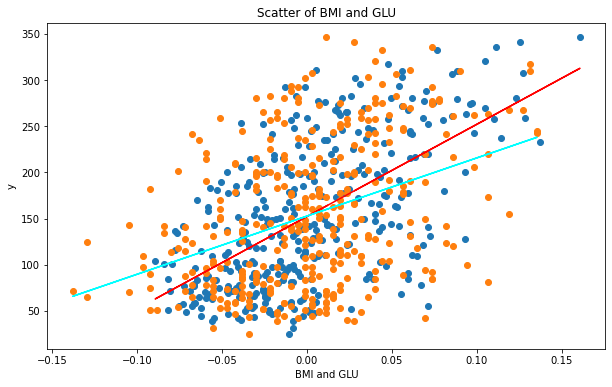

In [46]:
bmi = x_train_normal[:, np.newaxis, 2]
glu = x_train_normal[:, np.newaxis, 9]

y = y_train_normal[:, np.newaxis]

bmi_linear_regression = LinearRegression().fit(bmi, y_train_normal)
bmi_predicted_y = bmi_linear_regression.predict(bmi)

glu_linear_regression = LinearRegression().fit(glu, y_train_normal)
glu_predicted_y = glu_linear_regression.predict(glu)

# Plotting of the regression line on a scatterd plot
plt.figure(figsize=(10,6))
plt.scatter(bmi, y_train_normal)
plt.scatter(glu, y_train_normal)
plt.plot(bmi, bmi_predicted_y, c='r')
plt.plot(glu, glu_predicted_y, c='cyan')
plt.title('Scatter of BMI and GLU')
plt.ylabel('y')
plt.xlabel('BMI and GLU')
plt.show()

## Helper functions  

### Select features  
The job of the select features function is to first score all of our  
features in our dataset, and then remove all but the "k" best features  
in the dataset. This is important as we dont want to waste resources on  
computing features like sex, since these does not matter as much when  
it comes to type 2 diabetes progression. 

### Plot "k" best score 
The job of the plot "k" best score is the plot the scoring of each  
features after they have been scored by the __*"Select features"*__ function.  

### PCA features
The job of the PCA features function is to reduce the number of features  
in our dataset, while preserving as much information as possible. And  
there are generally two PCA techniques that is used:  
- Feature elemination
- Feature extraction  

In feature elemination we reduce the feature space by eliminating  
features that we expect will not be important in predicting the  
type 2 diabetes progression. The downside of this is that we gain  
no information about the features that we eliminated, which can hurt  
our overall accuracy of the type 2 diabetes prediction.

In feature extraction we start by creating new features which represents  
all of our dataset features. We then select the "n" best scoring features  
as the features we want to use to predict the type 2 diabetes progression.  
The advantage of this over feature elemination is that we can eliminated  
less important features, but still keep information about them. This  
will limit the accuracy loss when reducing our features.

The PCA features function implemented as a helper function uses *feature extraction*.

### Plot PCA variance
The job of the Plot PCA variance function is to plot the information coverage  
as we increase the number of feature we want to keep, as we perform PCA  
feature extraction on our dataset.

### Plot percent correct
The job of the Plot percent correct function is to plot the accuracy of  
a selected model.  

### Plot matrix
The job of the Plot matrix function is to plot a confusion matrix

In [48]:
def select_features(train_data, y_data, test_data, n_features='all', regression=True):
    score_function = f_regression
    if (regression):
        score_function = chi2

    k_best = SelectKBest(score_func=score_function, k=n_features)
    k_best.fit(train_data, y_data)
    
    x_train_k_best = k_best.transform(train_data)
    x_test_k_best = k_best.transform(test_data)

    return x_train_k_best, x_test_k_best, k_best

def plot_k_best_score(scores):
    plt.bar([i for i in range(len(scores))], scores)
    plt.title('Score value of each feature')
    plt.xlabel('Feature')
    plt.ylabel('Score')
    plt.show()

def pca_features(dataset, transform, n_features=5):
    pca = PCA(n_components=n_features).fit(dataset)

    transformed = pca.transform(transform)

    return transformed, pca

def plot_pca_variance(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.title('PCA coverage features')
    plt.xlabel('Features')
    plt.ylabel('Coverage')
    plt.show()

def print_percent_correct(predicted, test):
    print('Percentage correct:', 100*np.sum(predicted == test) / len(test))

def plot_matrix(title, matrix):
    cmap = ListedColormap(['darkorange', 'gold', 'blue', 'red'])

    plt.figure()
    plt.matshow(matrix)
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            plt.text(x=j, y=i, s=matrix[i,j], va='center', ha='center')
    
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

## Feature seleaction
In this section we use feature selection to limit the resources  
spent on training our model later. For this we will use two methods:  
- SelectKBest
- PCA - Principal component analysis  

For SelectKBest it is important that we do not have any negative  
values in our dataset etc. Therefore we have to use standarized data,  
with values between 0 and 1. *SelectKBest is described more in  
detail in the __"Helper function"__ section*.

For PCA it is also important that we use standarized or normalized  
data, so that the data is good to represent the relationship between  
the features in our dataset. *PCA is described more in detail in the  
__"Helper function"__ section*. 

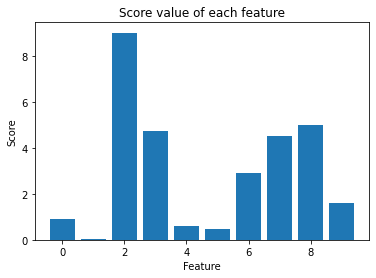

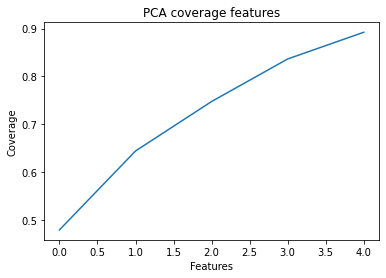

In [50]:
features = 5

x_trainset_features = x_train_standarized_labeled
y_trainset_features = y_train_labaled
x_testset_features = x_test_standarized_labeled

x_train_k_best, x_test_k_best, k_best = select_features(x_trainset_features, y_trainset_features, x_testset_features, n_features=features)
plot_k_best_score(k_best.scores_)

transformed, pca = pca_features(dataset=x_trainset_features, transform=x_trainset_features, n_features=features)
x_train_pca = transformed
transformed, pca = pca_features(dataset=x_testset_features, transform=x_testset_features, n_features=features)
x_test_pca = transformed
plot_pca_variance(pca)

# VERY IMPORTANT! SET TRAINING DATA HERE!
x_train = x_train_k_best
x_test = x_test_k_best
y_train = y_train_labaled
y_test = y_test_labaled

<Figure size 432x288 with 0 Axes>

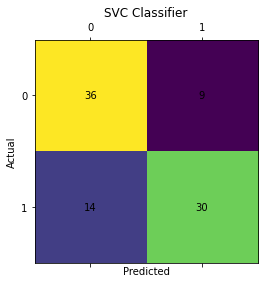

Percentage correct: 74.15730337078652


<Figure size 432x288 with 0 Axes>

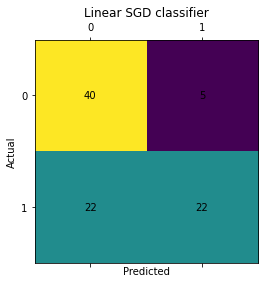

Percentage correct: 69.66292134831461


In [51]:
predicter = Sequential()

predicter.add(Dense(units=features*2, activation='relu', input_dim=features, name='Input'))
predicter.add(Dense(units=10, activation='relu', name='Hidden1'))
predicter.add(Dense(units=5, activation='relu', name='Hidden2'))
predicter.add(Dense(units=1, activation='sigmoid', name='Output'))

predicter.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['accuracy'])

svc_clf = SVC(random_state=42,kernel='rbf', C=2200, gamma=0.0001)
svc_clf.fit(x_train, y_train)
y_pred_svc = svc_clf.predict(x_test)
svc_clf.get_params

# Confusion matrix SVC
cm = confusion_matrix(y_true=y_test, y_pred=y_pred_svc)
plot_matrix('SVC Classifier', cm)
print_percent_correct(y_pred_svc, y_test)

# Linear SDG classifier using SVM(Support venctor machine)
sgd_clf = SGDClassifier(random_state=42, max_iter=2000, tol=0.001)
sgd_clf.fit(x_train, y_train)
y_pred_sdg = sgd_clf.predict(x_test)

# Confusion matrix SGD
cm2 = confusion_matrix(y_true=y_test, y_pred=y_pred_sdg)
plot_matrix('Linear SGD classifier', cm2)
print_percent_correct(y_pred_sdg, y_test)

In [52]:
history = predicter.fit(x = x_train, y = y_train, epochs=200, batch_size=64, shuffle=True, validation_data=(x_test, y_test), verbose=1)

_accuracy: 0.7303
Epoch 59/200
6/6 [==============================] - 0s 6ms/step - loss: 0.5404 - accuracy: 0.7564 - val_loss: 0.5382 - val_accuracy: 0.7416
Epoch 60/200
6/6 [==============================] - 0s 7ms/step - loss: 0.5390 - accuracy: 0.7535 - val_loss: 0.5360 - val_accuracy: 0.7303
Epoch 61/200
6/6 [==============================] - 0s 8ms/step - loss: 0.5364 - accuracy: 0.7649 - val_loss: 0.5339 - val_accuracy: 0.7303
Epoch 62/200
6/6 [==============================] - 0s 7ms/step - loss: 0.5335 - accuracy: 0.7535 - val_loss: 0.5320 - val_accuracy: 0.7416
Epoch 63/200
6/6 [==============================] - 0s 7ms/step - loss: 0.5322 - accuracy: 0.7620 - val_loss: 0.5304 - val_accuracy: 0.7416
Epoch 64/200
6/6 [==============================] - 0s 7ms/step - loss: 0.5297 - accuracy: 0.7535 - val_loss: 0.5289 - val_accuracy: 0.7416
Epoch 65/200
6/6 [==============================] - 0s 7ms/step - loss: 0.5283 - accuracy: 0.7592 - val_loss: 0.5273 - val_accuracy: 0.7303
Ep

[0.94914496 0.13231581 0.13277873 0.82739747 0.4989109  0.68945515
 0.27112156 0.3505808  0.82268894 0.05649242 0.1864652  0.11330357
 0.76927483 0.77305174 0.6855848  0.06911656 0.96689343 0.11351281
 0.0874899  0.3324117  0.08657113 0.09404647 0.16456303 0.61325276
 0.54144585 0.3681742  0.10249829 0.09784123 0.10285333 0.30098647
 0.43489888 0.70971256 0.7576417  0.21246019 0.6820594  0.64510906
 0.72687507 0.3697964  0.11802018 0.6489488  0.86742496 0.5232029
 0.8185968  0.37175035 0.24847451 0.7561723  0.3595311  0.32761663
 0.8285316  0.10999963 0.9424715  0.07249701 0.41289386 0.12325445
 0.5706661  0.394409   0.89450884 0.09789833 0.4009646  0.26822242
 0.95928764 0.60393596 0.34376687 0.6795623  0.2874651  0.4217654
 0.8185616  0.14913848 0.18529642 0.49802938 0.13672805 0.93658185
 0.7386197  0.11498049 0.5527586  0.63291204 0.9655807  0.15319604
 0.18095633 0.6250887  0.13757756 0.0731844  0.11288175 0.89364225
 0.44322777 0.62224483 0.08381414 0.6748992  0.5485704 ]
[1. 0. 

<Figure size 432x288 with 0 Axes>

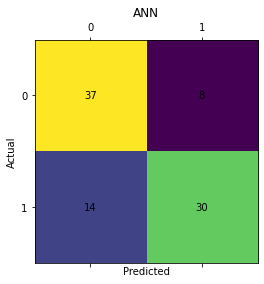

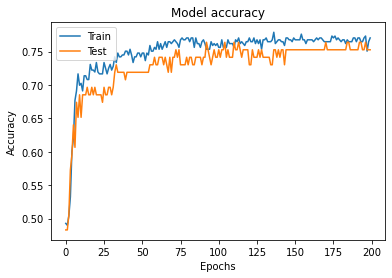

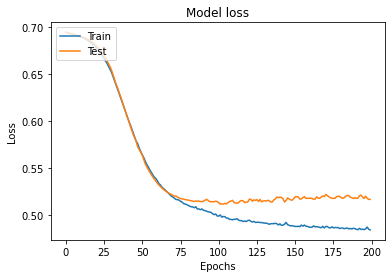

In [53]:
pr = predicter.predict(x_test)
pr_reformed = pr[:,0]
print(pr_reformed)
pr_transformed = np.zeros(len(pr))
pr_transformed[pr_reformed > 0.5] = 1
print(pr_transformed)

ann_cm = confusion_matrix(y_true=y_test, y_pred=pr_transformed)
plot_matrix('ANN', ann_cm)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

accuracy:  74.15730337078652


<Figure size 432x288 with 0 Axes>

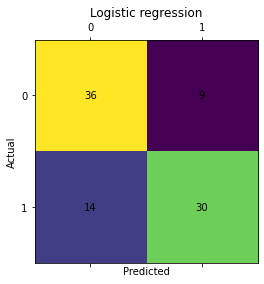

In [54]:
model = LogisticRegression(penalty = 'l2', random_state = 0)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print('accuracy: ',accuracy_score(y_test, y_pred)*100)

cm = confusion_matrix(y_test, y_pred)
plot_matrix("Logistic regression", cm)

76.40449438202246


<Figure size 432x288 with 0 Axes>

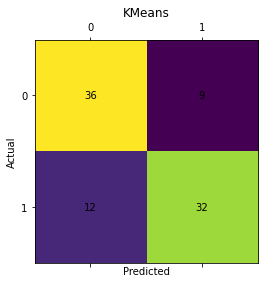

In [55]:
k_means = KMeans(n_clusters=2, max_iter=100, algorithm='auto', random_state=42, verbose=0)
k_means.fit(x_train)
k_means_predicted = k_means.predict(x_test)
print(accuracy_score(y_test, k_means_predicted)*100)
k_means_cm = confusion_matrix(y_true=y_test, y_pred = k_means_predicted)
plot_matrix('KMeans', k_means_cm)